# Binding multimodal data using ImageBind and OpenVINO

[ImageBind](https://github.com/facebookresearch/ImageBind) is the first AI model capable of binding data from six modalities at once, without the need for explicit supervision. By recognizing the relationships between these modalities — images and video, audio, text, depth, thermal and inertial measurement units (IMUs) — this breakthrough helps advance AI by enabling machines to better analyze many different forms of information, together.

![ImageBind](https://user-images.githubusercontent.com/8495451/236859695-ffa13364-3e39-4d99-a8da-fbfab17f9a6b.gif)

In this tutorial we consider how to convert and run ImageBind model using OpenVINO.

The tutorial consist of following steps:
1. Download pre-trained model.
2. Prepare input data examples.
3. Convert model to OpenVINO Intermediate Representation format (IR).
4. Run model inference and analyze results.

## Prerequisites

In [1]:
!pip install -q soundfile "pytorchvideo @ git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d" ftfy "timm==0.6.7" einops fvcore "decord==0.6.0" torchaudio==0.13.1

In [2]:
from pathlib import Path

repo_dir = Path("ImageBind")

if not repo_dir.exists():
    !git clone https://github.com/facebookresearch/ImageBind.git

%cd {repo_dir}

Cloning into 'ImageBind'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 71 (delta 19), reused 12 (delta 12), pack-reused 40
Unpacking objects: 100% (71/71), 2.63 MiB | 3.06 MiB/s, done.
/home/ea/work/openvino_notebooks/notebooks/240-image-bind/ImageBind


## Instantiate PyTorch model

In [4]:
import data
import torch
from models import imagebind_model
from models.imagebind_model import ModalityType

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval();

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

## Prepare input data

In [5]:
# Prepare inputs

text_list=["A car", "A bird", "A dog"]
image_paths=[".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
audio_paths=[".assets/dog_audio.wav", ".assets/bird_audio.wav", ".assets/car_audio.wav"]

inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, "cpu"),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, "cpu"),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, "cpu"),
}

## Convert Model to OpenVINO Intermediate Representation (IR) format

In [6]:
class ModelExportText(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
  
    def forward(self, text):
        return self.model({"text": text})

class ModelExportVision(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
  
    def forward(self, vision):
        return self.model({"vision": vision})

class ModelExportAudio(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
  
    def forward(self, audio):
        return self.model({"audio": audio})

In [7]:
from openvino.tools import mo
from openvino.runtime import serialize, Core

core = Core()
device = "CPU"

ov_modality_models = {}

exporters = [ModelExportText, ModelExportVision, ModelExportAudio]
modalities = [ModalityType.TEXT, ModalityType.VISION, ModalityType.AUDIO]
for exporter, modality in zip(exporters, modalities):
    export_dir = Path(f"image-bind-{modality}")
    file_name = f"image-bind-{modality}"
    export_dir.mkdir(exist_ok=True)
    onnx_path = export_dir / "onnx" / f"{file_name}.onnx"
    onnx_path.parent.mkdir(exist_ok=True)
    ir_path = export_dir / onnx_path.name.replace(".onnx", ".xml")
    if not ir_path.exists():
        if not onnx_path.exists():
            exportable_model = exporter(model)
            model_input = inputs[modality]
            torch.onnx.export(exportable_model, model_input, str(onnx_path), input_names=["input"], dynamic_axes={"input": {0: "batch_size"}})
        ov_model = mo.convert_model(onnx_path, compress_to_fp16=True)
        serialize(ov_model, str(ir_path))
    else:
        ov_model = core.read_model(ir_path)
    ov_modality_models[modality] = core.compile_model(ov_model, device)

/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:5408: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(
/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/torch/onnx/utils.py:687: UserWarning: The shape infer

## Run Model Inference

In [8]:
embeddings = {}
for modality in modalities:
    embeddings[modality] = ov_modality_models[modality](inputs[modality])[0]

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax


def visualize_prob_matrix(matrix, x_label, y_label):
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    ax.matshow(matrix, cmap='prism')

    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
        ax.set_xticks(range(len(x_label)), x_label)
        ax.set_yticks(range(len(y_label)), y_label)

image_list = [img.split('/')[-1] for img in image_paths]
audio_list = [audio.split('/')[-1] for audio in audio_paths]

In [10]:
text_vision_scores = softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, axis=-1)

visualize_prob_matrix(text_vision_scores, text_list, image_list)

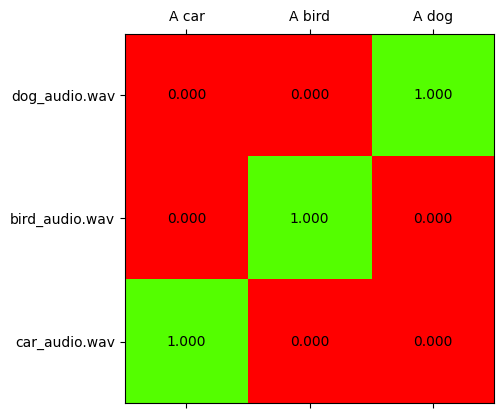

In [11]:
text_audio_scores = softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, axis=-1)

visualize_prob_matrix(text_audio_scores, text_list, audio_list)

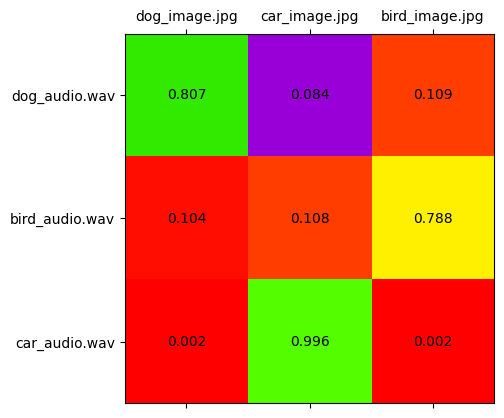

In [12]:
audio_vision_scores = softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, axis=-1)

visualize_prob_matrix(audio_vision_scores, image_list, audio_list)

Predicted label: A car 
probability for image - 1.000
probability for audio - 1.000


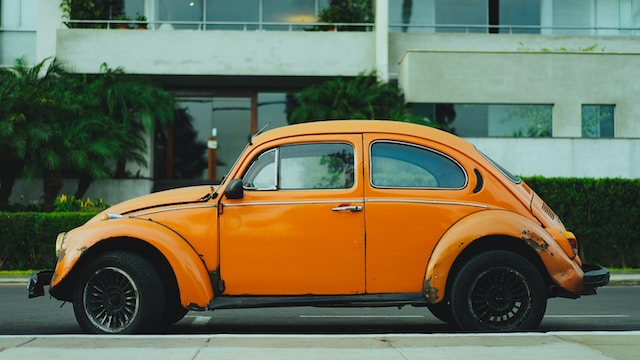

In [13]:
import IPython.display as ipd
from PIL import Image
text_image_ids = np.argmax(text_vision_scores, axis=0)
text_audio_ids = np.argmax(text_audio_scores, axis=0)
print(f"Predicted label: {text_list[0]} \nprobability for image - {text_vision_scores[text_image_ids[0], 0]:.3f}\nprobability for audio - {text_audio_scores[0, text_audio_ids[0]]:.3f}")
display(Image.open(image_paths[text_image_ids[0]]))
ipd.Audio(audio_paths[text_audio_ids[0]])

Predicted label: A bird 
probability for image - 0.987
probability for audio - 1.000


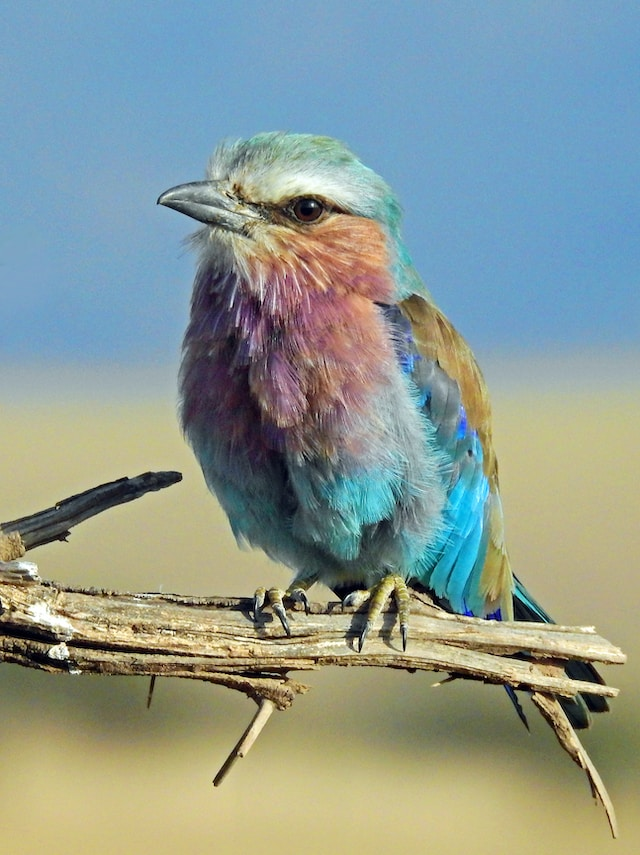

In [14]:
print(f"Predicted label: {text_list[1]} \nprobability for image - {text_vision_scores[text_image_ids[1], 1]:.3f}\nprobability for audio - {text_audio_scores[1, text_audio_ids[1]]:.3f}")
display(Image.open(image_paths[text_image_ids[1]]))
ipd.Audio(audio_paths[text_audio_ids[1]])

Predicted label: A dog 
probability for image - 0.984
probability for audio - 1.000


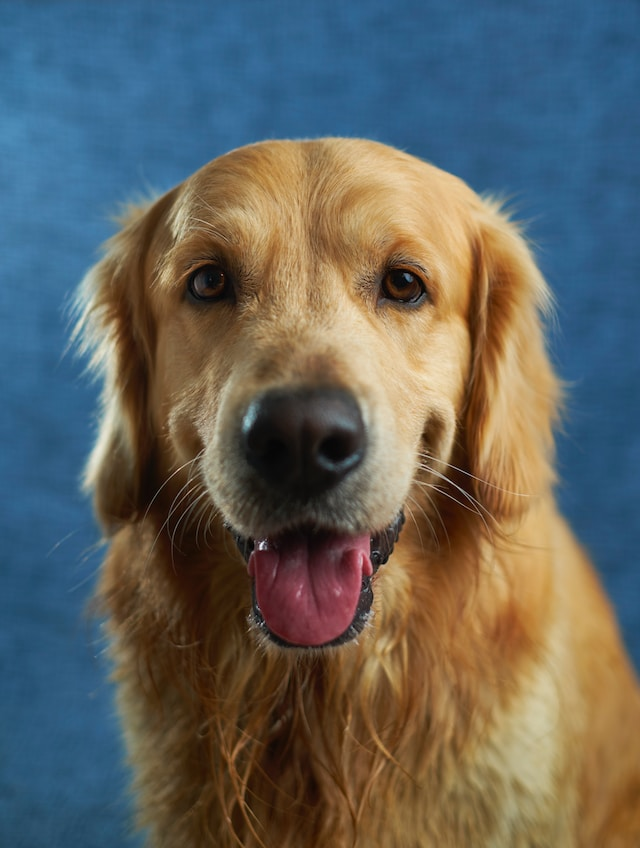

In [15]:
print(f"Predicted label: {text_list[2]} \nprobability for image - {text_vision_scores[text_image_ids[2], 2]:.3f}\nprobability for audio - {text_audio_scores[2, text_audio_ids[2]]:.3f}")
display(Image.open(image_paths[text_image_ids[2]]))
ipd.Audio(audio_paths[text_audio_ids[2]])